# Análisis Exploratorio de las Etiquetas

### Importar librerías



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib

In [2]:
plt.style.use("seaborn-v0_8-darkgrid")

### Limpiar el data set
(Eliminar registros que no son del pecho)

In [3]:
df1 = pd.read_csv("../datos/labels/train_predicted_labels.csv")   

with open("../datos/labels/no_chest_train.txt", "r") as f:
    rutas_largas = f.read().splitlines()
nombres_largos = [ruta.split("/")[-1] for ruta in rutas_largas]
df = df1[~df1.iloc[:,0].isin(nombres_largos)].copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46397 entries, 0 to 47148
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   VolumeName                          46397 non-null  object
 1   Medical material                    46397 non-null  int64 
 2   Arterial wall calcification         46397 non-null  int64 
 3   Cardiomegaly                        46397 non-null  int64 
 4   Pericardial effusion                46397 non-null  int64 
 5   Coronary artery wall calcification  46397 non-null  int64 
 6   Hiatal hernia                       46397 non-null  int64 
 7   Lymphadenopathy                     46397 non-null  int64 
 8   Emphysema                           46397 non-null  int64 
 9   Atelectasis                         46397 non-null  int64 
 10  Lung nodule                         46397 non-null  int64 
 11  Lung opacity                        46397 non-null  int64 


In [5]:
df.head()

,VolumeName,Medical material,Arterial wall calcification,Cardiomegaly,Pericardial effusion,Coronary artery wall calcification,Hiatal hernia,Lymphadenopathy,Emphysema,Atelectasis,Lung nodule,Lung opacity,Pulmonary fibrotic sequela,Pleural effusion,Mosaic attenuation pattern,Peribronchial thickening,Consolidation,Bronchiectasis,Interlobular septal thickening
0,train_1_a_1.nii.gz,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0
1,train_1_a_2.nii.gz,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0
2,train_2_a_1.nii.gz,0,1,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0
3,train_2_a_2.nii.gz,0,1,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0
4,train_3_a_1.nii.gz,0,1,1,0,1,0,1,0,0,1,1,1,0,0,1,0,1,0


In [6]:
disease_cols = df.columns[2:] #1 si medical material es enfermedad y 2 si no
disease_counts = df[disease_cols].sum().sort_values(ascending=False)
disease_counts


Lung nodule                           21096
Lung opacity                          17147
Arterial wall calcification           13016
Pulmonary fibrotic sequela            12411
Atelectasis                           11968
Lymphadenopathy                       11939
Coronary artery wall calcification    11663
Emphysema                              8996
Consolidation                          8223
Hiatal hernia                          6618
Pleural effusion                       5593
Cardiomegaly                           5025
Peribronchial thickening               4911
Bronchiectasis                         4691
Interlobular septal thickening         3688
Mosaic attenuation pattern             3487
Pericardial effusion                   3332
dtype: int64

In [7]:
total_registros = disease_counts.sum()
print(f"Total de registros: {total_registros:,}")


Total de registros: 153,804


# Gráficas

### Barras

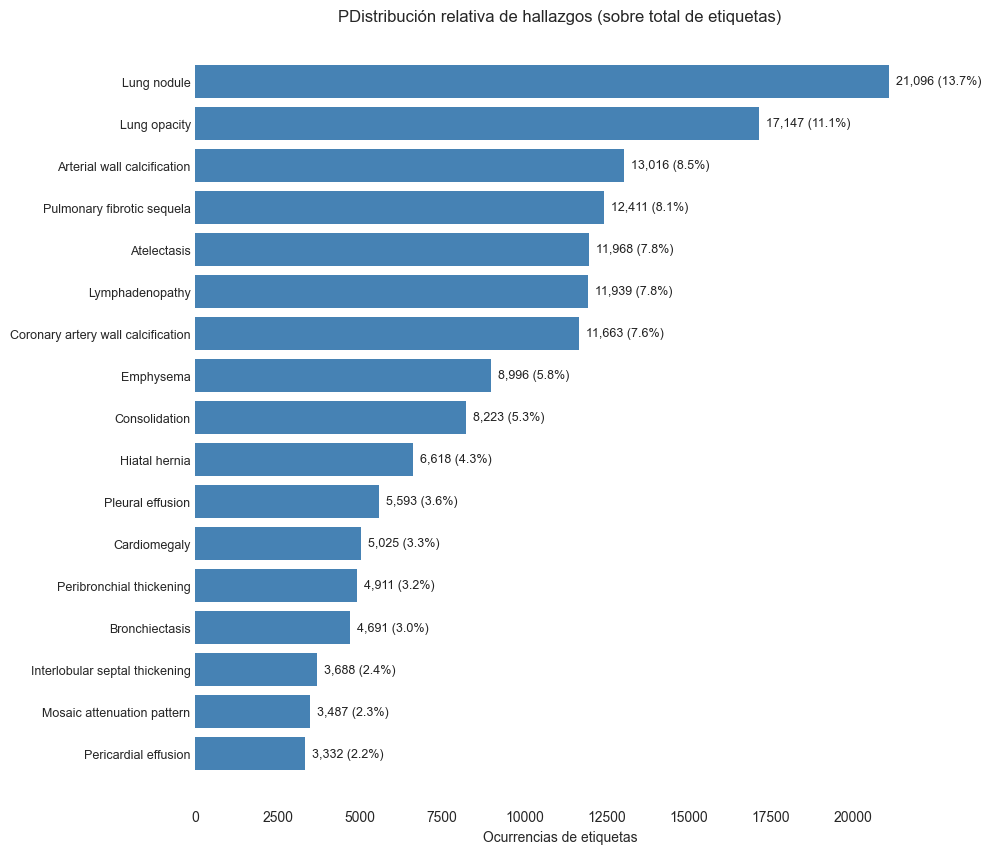

In [31]:
counts = disease_counts.sort_values(ascending=True)
total_hallazgos = counts.sum()
disease_percentages = counts / total_hallazgos * 100

plt.figure(figsize=(10, 0.45*len(counts)+1), facecolor="white")
ax = plt.gca()
ax.set_facecolor("white")

ax.barh(range(len(counts)), counts.values, color="steelblue")

m = counts.max()
for i, (c, p) in enumerate(zip(counts.values, disease_percentages.values)):
    ax.text(c + m*0.01, i, f"{c:,} ({p:.1f}%)", va='center', fontsize=9, color="#222")

ax.set_yticks(range(len(counts)))
ax.set_yticklabels(counts.index, fontsize=9)
ax.set_xlabel("Ocurrencias de etiquetas")
ax.set_title("PDistribución relativa de hallazgos (sobre total de etiquetas)")

for spine in ("top","right"):
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

### Nota
La gráfica muestra la composición relativa de todas las etiquetas positivas del conjunto: cada barra indica cuántas veces se registró un hallazgo y el porcentaje entre paréntesis corresponde a su proporción sobre el total de etiquetas (no es la prevalencia de pacientes, sino la fracción de todas las anotaciones positivas).

### Heat map

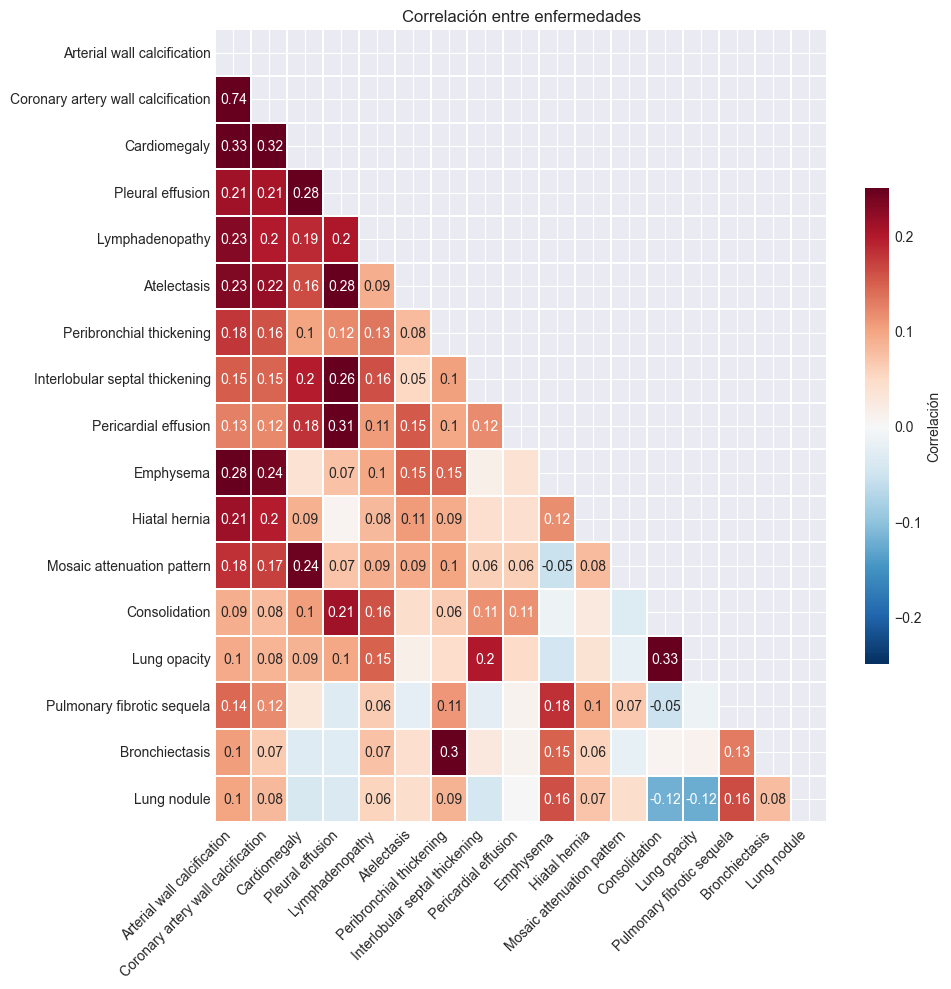

In [32]:
corr = df[disease_cols].corr()
vals, vecs = np.linalg.eigh(corr)
pc1 = vecs[:, vals.argmax()]
order = np.argsort(pc1)
corr_o = corr.iloc[order, order]

mask = np.triu(np.ones_like(corr_o, dtype=bool))

ann = corr_o.round(2).astype(str)
ann[np.abs(corr_o.values) < 0.05] = ""

plt.figure(figsize=(10,10))
sns.heatmap(
    corr_o,
    mask=mask,
    cmap="RdBu_r",
    center=0,
    vmin=-0.25, vmax=0.25,
    linewidths=.3,
    annot=ann,
    fmt="",
    cbar_kws={"shrink":0.6, "label":"Correlación"}
)
plt.title("Correlación entre enfermedades")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Nota

Este mapa muestra qué tan seguido aparecen juntas dos condiciones en los mismos estudios. Cada cuadradito compara un par:

Rojo: las dos suelen salir juntas más de lo esperado.
Azul: casi no coinciden (aparecen separadas).
Blanco o muy claro: no hay relación clara.
La escala va de -0.25 a +0.25 (valores fuera de ese rango se “recortan” para que los colores se distingan mejor). No significa porcentaje, solo indica fuerza y dirección de la relación. No implica causa; solo refleja coincidencia en este conjunto de datos

# 🫀 **Cardiovasculares**

### **Arterial wall calcification** (Calcificación de la pared arterial)

**¿Qué es?** Depósitos de calcio en la pared arterial (frecuente en aorta, coronarias y arterias periféricas).

**Causas:** Aterosclerosis asociada a envejecimiento y factores de riesgo: diabetes mellitus, enfermedad renal crónica, hipertensión, dislipidemia, tabaquismo e inflamación crónica.

**Significado:** Indicador de aterosclerosis, rigidez arterial y degeneración vascular crónica. 

**En CT:** Focos o líneas hiperdensas adheridas a la pared (visibles sin contraste). 

**Relevancia:** Marcador de riesgo cardiovascular y posible dificultad técnica en procedimientos.  

In [41]:
cond = "Arterial wall calcification"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Arterial wall calcification: 13,016 registros (8.46%).


### **Coronary artery wall calcification** (Calcificación de la pared arterial coronaria)

**¿Qué es?** Depósitos de calcio en la pared de las arterias coronarias.

**Causas:** Aterosclerosis relacionada con envejecimiento y factores de riesgo cardiovascular: diabetes mellitus, enfermedad renal crónica (alteración calcio-fosfato), hipertensión, dislipidemia, tabaquismo e inflamación crónica.

**Significado:** Indicador de aterosclerosis coronaria, rigidez arterial y carga aterosclerótica total.

**En CT:** Se visualiza como focos o líneas hiperdensas en la pared coronaria (sin contraste). Se cuantifica con el Agatston score.

**Relevancia:** Marcador de riesgo cardiovascular mayor, predictor de eventos coronarios (infarto de miocardio), y útil en estratificación de riesgo para prevención.

In [38]:
cond = "Coronary artery wall calcification"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Coronary artery wall calcification: 11,663 registros (7.58%).


### **Cardiomegaly** (Cardiomegalia)

**¿Qué es?** Aumento del tamaño global del corazón o de sus cavidades, visible en estudios de imagen.

**Causas:** Hipertensión arterial crónica, cardiopatía isquémica, miocardiopatías (dilatada, hipertrófica, restrictiva), valvulopatías (estenosis o insuficiencia aórtica/mitral), enfermedad pericárdica (derrame), anemia crónica, alteraciones tiroideas, alcoholismo.

**Significado:** Indica sobrecarga de presión o volumen, remodelado cardíaco y riesgo de insuficiencia cardíaca.

**En CT:** Corazón de tamaño aumentado, con diámetros de cavidades dilatados o masa miocárdica incrementada. En Rx de tórax: índice cardiotorácico > 0.5.

**Relevancia:** Marcador de insuficiencia cardíaca, riesgo de arritmias y predictor de mal pronóstico cardiovascular.

In [39]:
cond = "Cardiomegaly"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Cardiomegaly: 5,025 registros (3.27%).


### **Pericardial effusion** (Derrame pericárdico)

**¿Qué es?** Acumulación anormal de líquido en el espacio pericárdico.

**Causas:** Infecciones (virus, bacterias, tuberculosis), neoplasias, insuficiencia cardíaca, insuficiencia renal (uremia), enfermedades autoinmunes (lupus, artritis reumatoide), traumatismos, postquirúrgico, hipotiroidismo, idiopático.

**Significado:** Indica inflamación, lesión o compromiso sistémico; puede evolucionar a taponamiento cardíaco si el volumen es significativo o de rápida acumulación.

**En CT:** Engrosamiento aparente del espacio pericárdico con líquido hipodenso que rodea al corazón; en ecocardiografía se confirma y cuantifica.

**Relevancia:** Puede comprometer el llenado cardíaco (taponamiento), generar inestabilidad hemodinámica y requerir drenaje (pericardiocentesis).

In [42]:
cond = "Pericardial effusion"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Pericardial effusion: 3,332 registros (2.17%).


# 🫁 Pulmonares


### Emphysema

Qué es: Destrucción de alvéolos → hiperinsuflación y áreas sin intercambio gaseoso.

En CT: Áreas hipodensas (negras) sin paredes vasculares, con aumento del tamaño pulmonar.


In [14]:
print(f" presente en {disease_counts["Emphysema"]} registros ({disease_percentages["Emphysema"]:.2f}%)")

 presente en 8996 registros (5.85%)



### Atelectasis

Qué es: Colapso parcial o completo del pulmón o de un segmento.

En CT: Disminución de volumen, desplazamiento de estructuras y aumento de densidad local.

In [15]:
print(f" presente en {disease_counts["Atelectasis"]} registros ({disease_percentages["Atelectasis"]:.2f}%)")

 presente en 11968 registros (7.78%)



### Lung nodule



Qué es: Lesión redondeada <3 cm dentro del pulmón. Puede ser benigna o maligna.

En CT: Opacidad focal bien delimitada, evaluable en tamaño, bordes y atenuación.

In [16]:
print(f" presente en {disease_counts["Lung nodule"]} registros ({disease_percentages["Lung nodule"]:.2f}%) Patología más común en el data set")

 presente en 21096 registros (13.72%) Patología más común en el data set


### Lung opacity

Qué es: Cualquier aumento de densidad en el pulmón (ej. neumonía, edema, hemorragia).

En CT: Zona blanca dentro del parénquima, de extensión variable.

In [17]:
disease_counts["Lung opacity"]
print(f" presente en {disease_counts["Lung opacity"]} registros ({disease_percentages["Lung opacity"]:.2f}%)")

 presente en 17147 registros (11.15%)


### Pulmonary fibrotic sequela

Qué es: Cicatrización del pulmón tras inflamación o infección crónica.

En CT: Reticulación, bronquiectasias por tracción, distorsión arquitectónica.

In [18]:
print(f" presente en {disease_counts["Pulmonary fibrotic sequela"]} registros ({disease_percentages["Pulmonary fibrotic sequela"]:.2f}%)")

 presente en 12411 registros (8.07%)




### Mosaic attenuation pattern

Qué es: Diferencias en la densidad pulmonar por alteraciones vasculares o de vía aérea.

En CT: Áreas alternadas de mayor y menor atenuación en parénquima pulmonar.

In [19]:
print(f" presente en {disease_counts["Mosaic attenuation pattern"]} registros ({disease_percentages["Mosaic attenuation pattern"]:.2f}%)")

 presente en 3487 registros (2.27%)


### Peribronchial thickening

Qué es: Engrosamiento de las paredes bronquiales, asociado a inflamación o infección crónica.

En CT: Anillos bronquiales engrosados (“donut sign”), bronquios más visibles.

In [20]:
print(f" presente en {disease_counts["Peribronchial thickening"]} registros ({disease_percentages["Peribronchial thickening"]:.2f}%)")

 presente en 4911 registros (3.19%)


### Consolidation

Qué es: Sustitución de aire alveolar por líquido, células o exudado (ej. neumonía).

En CT: Opacidad homogénea que borra los vasos y bronquios.

In [21]:
print(f" presente en {disease_counts["Consolidation"]} registros ({disease_percentages["Consolidation"]:.2f}%)")

 presente en 8223 registros (5.35%)


### Bronchiectasis

Qué es: Dilatación irreversible de los bronquios.

En CT: Bronquios dilatados > diámetro de arterias adyacentes, con engrosamiento de la pared.

In [22]:
print(f" presente en {disease_counts["Bronchiectasis"]} registros ({disease_percentages["Bronchiectasis"]:.2f}%)")

 presente en 4691 registros (3.05%)


### Interlobular septal thickening

Qué es: Engrosamiento de los septos interlobulares por líquido, fibrosis o infiltración.

En CT: Líneas finas que delimitan lobulillos secundarios, patrón reticular.

In [23]:
print(f" presente en {disease_counts["Interlobular septal thickening"]} registros ({disease_percentages["Interlobular septal thickening"]:.2f}%)")

 presente en 3688 registros (2.40%)



# 🫁🫀 Otros hallazgos torácicos

### Pleural effusion

Qué es: Acumulación de líquido en la cavidad pleural.

En CT: Colección hipodensa en el espacio pleural, con menisco característico.

In [24]:
print(f" presente en {disease_counts["Pleural effusion"]} registros ({disease_percentages["Pleural effusion"]:.2f}%)")

 presente en 5593 registros (3.64%)


### Lymphadenopathy

Qué es: Agrandamiento patológico de ganglios linfáticos (ej. por infección, tumor, inflamación).

En CT: Nódulos redondeados o lobulados en mediastino, >10 mm eje corto.

In [25]:
print(f" presente en {disease_counts["Lymphadenopathy"]} registros ({disease_percentages["Lymphadenopathy"]:.2f}%)")

 presente en 11939 registros (7.76%)


### Hiatal hernia

Qué es: Protrusión del estómago a través del diafragma hacia el tórax.

En CT: Masa con densidad de aire/líquido detrás del corazón, en hiato esofágico.

In [26]:
print(f" presente en {disease_counts["Hiatal hernia"]} registros ({disease_percentages["Hiatal hernia"]:.2f}%)")

 presente en 6618 registros (4.30%)


# Número de enfermedades por registro 

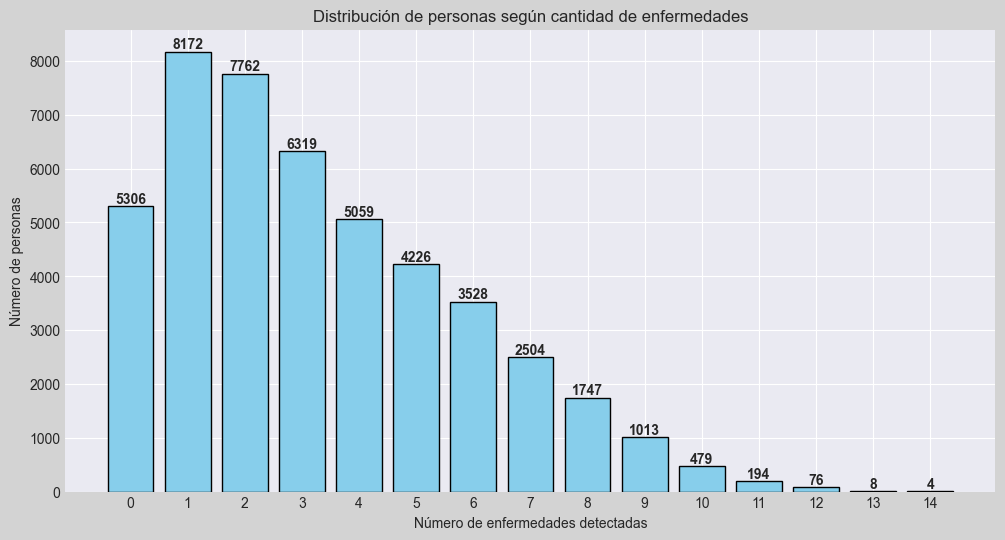

In [27]:
df.loc[:, "n_enfermedades"] = df[disease_cols].sum(axis=1)

rango = range(0, int(df["n_enfermedades"].max()) + 1)
conteo = df["n_enfermedades"].value_counts().reindex(rango, fill_value=0)

plt.figure(figsize=(12,6), facecolor="lightgrey")
bars = plt.bar(conteo.index, conteo.values, color="skyblue", edgecolor="black")

plt.xlabel("Número de enfermedades detectadas")
plt.ylabel("Número de personas")
plt.title("Distribución de personas según cantidad de enfermedades")
plt.xticks(conteo.index)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 1,
        f"{int(height)}",
        ha="center", va="bottom", fontsize=10, fontweight="bold"
    )

plt.show()

### Notar que no existen registros con mas de 14 patoligías a la vez